<a href="https://colab.research.google.com/github/arizzi/NNTutorial/blob/master/Jet_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
if os.path.isfile('jetImage_Merged.h5') :
    print ("File already downloaded")
else:
    !wget http://cern.ch/arizzi/jetImage_Merged.h5
  

--2019-12-01 13:55:15--  http://cern.ch/arizzi/jetImage_Merged.h5
Resolving cern.ch (cern.ch)... 188.184.9.234, 2001:1458:201:70::100:26
Connecting to cern.ch (cern.ch)|188.184.9.234|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://arizzi.web.cern.ch/arizzi/jetImage_Merged.h5 [following]
--2019-12-01 13:55:15--  http://arizzi.web.cern.ch/arizzi/jetImage_Merged.h5
Resolving arizzi.web.cern.ch (arizzi.web.cern.ch)... 188.185.67.197, 2001:1458:d00:1::100:3bf
Connecting to arizzi.web.cern.ch (arizzi.web.cern.ch)|188.185.67.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424649804 (405M) [text/plain]
Saving to: ‘jetImage_Merged.h5’

jetImage_Merged.h5  100%[===================>] 404.98M  26.3MB/s    in 19s     

2019-12-01 13:55:35 (20.9 MB/s) - ‘jetImage_Merged.h5’ saved [424649804/424649804]



In [0]:
# run the following only once
#!cp jetImage_Merged.h5 jetImage_Merged2.h5
#!mkdir models

# Notebook 2: train a Deep Neural Network with dense layers
In this notebook, we will
- Load the data from the usual file
- build the feature and the target array
- define a DNN with three layers, fixing node number, activation function, etc
- train the model, using Early Stopping and dynamic learning rate 
- check training history
- check training performances: AUC and confusion matrix

In [0]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from keras.regularizers import l1

Using TensorFlow backend.


In [0]:
%matplotlib inline

In [0]:
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

# Dataset preparation

In [0]:
try:
  f = h5py.File("jetImage_Merged.h5",'r')
except:
  print("try copying to avoid lock issues")
  !cp jetImage_Merged.h5 jetImage_Merged2.h5
  f = h5py.File("jetImage_Merged2.h5",'r')
jets = f.get('jets')
y = np.array(jets[:,-6:-1])
X = np.array(jets[:,:-6])

---
Split the dataset as follows:
- 2/3 for training
- 1/3 for validation 
---

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(65660, 53) (32341, 53) (65660, 5) (32341, 5)


# Build the model

In [0]:
batch_size = 128
n_epochs = 500
dropoutRate = 0.25

In [0]:
inputLayer = Input(shape=(53,))
x = BatchNormalization()(inputLayer)
####
x = Dense(30, activation='relu')(x)
x = Dropout(dropoutRate)(x)
####
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
####
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
####
outputLayer = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputLayer, outputs=outputLayer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 53)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53)                212       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1620      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                21

# Train the model

In [0]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_test, y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 65660 samples, validate on 32341 samples
Epoch 1/500





 - 2s - loss: 1.2543 - val_loss: 0.8919
Epoch 2/500
 - 1s - loss: 1.0183 - val_loss: 0.8211
Epoch 3/500
 - 1s - loss: 0.9651 - val_loss: 0.7713
Epoch 4/500
 - 1s - loss: 0.9299 - val_loss: 0.7211
Epoch 5/500
 - 1s - loss: 0.9005 - val_loss: 0.6783
Epoch 6/500
 - 1s - loss: 0.8859 - val_loss: 0.6738
Epoch 7/500
 - 1s - loss: 0.8722 - val_loss: 0.6561
Epoch 8/500
 - 1s - loss: 0.8580 - val_loss: 0.6576
Epoch 9/500
 - 1s - loss: 0.8488 - val_loss: 0.6396
Epoch 10/500
 - 1s - loss: 0.8430 - val_loss: 0.6452
Epoch 11/500
 - 1s - loss: 0.8354 - val_loss: 0.6326
Epoch 12/500
 - 1s - loss: 0.8302 - val_loss: 0.6290
Epoch 13/500
 - 1s - loss: 0.8230 - val_loss: 0.6178
Epoch 14/500
 - 1s - loss: 0.8214 - val_loss: 0.6196
Epoch 15/500
 - 1s - loss: 0.8161 - val_loss: 0.6267

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00

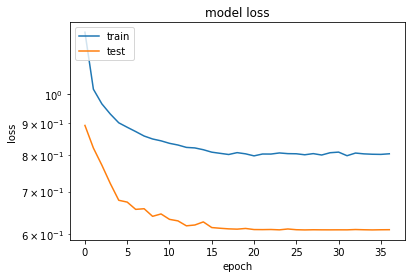

In [0]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#

# Store model into files

In [0]:
name = 'DNN_Small'

In [0]:
model_json = model.to_json()
!mkdir models
with open("models/jetTagger_%s.json" %name, "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/jetTagger_%s.h5" %name)

# Read model

In [0]:
from keras.models import model_from_json
# load json and create model
json_file = open("models/jetTagger_%s.json" %name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/jetTagger_%s.h5" %name)
print("Loaded model from disk")

Loaded model from disk


# Check Performances

In [0]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']

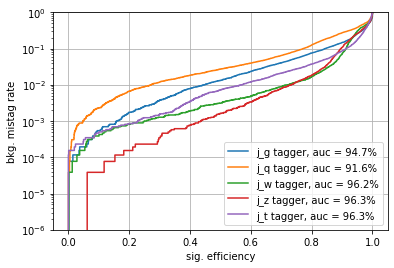

In [0]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_test = model.predict(X_test)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_test[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5135  553   98  115  715]
 [ 973 4232  267  238  549]
 [ 146  446 5622  259   65]
 [ 194  414  287 5404  102]
 [ 429   95  226  183 5594]]
Normalized confusion matrix
[[0.78 0.08 0.01 0.02 0.11]
 [0.16 0.68 0.04 0.04 0.09]
 [0.02 0.07 0.86 0.04 0.01]
 [0.03 0.06 0.04 0.84 0.02]
 [0.07 0.01 0.03 0.03 0.86]]


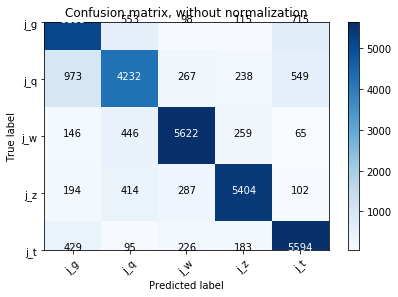

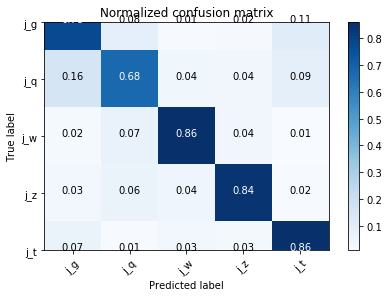

In [0]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predict_test, axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Next part of the tutorial

https://colab.research.google.com/github/arizzi/NNTutorial/blob/master/Architecture_Examples.ipynb
